# `Gesture predictions based on surface electromyography using machine learning tools.`

# INFO-F-422 - Statistical foundations of machine learning Project 2024-2025
_2024-2025 - Gianluca Bontempi, Cédric Simar, Pascal Tribell_



### Group n°X: The Goats 🐐
_Antoine Figula, Arthur Robert, Victor Wattel_


The following code is structures along X great part :
- 0. Data loading and visualization 
- 1. Data preparation
- 2. Cross-Validation
- 3. Baseline approach
- 4. Advanced approach
- 5. Ensembling strategy
- 6. Final predictions
- 7. Predictions visualizations


## 0. Data loading and visualization



Library imports

In [1]:
#libraries 
import numpy as np
import pandas as pd
import  matplotlib.pyplot as plt


Data loading

In [2]:
#guided dataset and testset
guided_dataset_X = np.load('/Users/victorwattel/Library/Mobile Documents/com~apple~CloudDocs/Desktop/INFO-F-422 Statistical fundations of ML /Project/F422 EMG project data/guided/guided_dataset_X.npy')
guided_dataset_y = np.load('/Users/victorwattel/Library/Mobile Documents/com~apple~CloudDocs/Desktop/INFO-F-422 Statistical fundations of ML /Project/F422 EMG project data/guided/guided_dataset_y.npy')
guided_testset_X = np.load('/Users/victorwattel/Library/Mobile Documents/com~apple~CloudDocs/Desktop/INFO-F-422 Statistical fundations of ML /Project/F422 EMG project data/guided/guided_testset_X.npy')

#freemoves dataset and testset
freemoves_dataset_X = np.load('/Users/victorwattel/Library/Mobile Documents/com~apple~CloudDocs/Desktop/INFO-F-422 Statistical fundations of ML /Project/F422 EMG project data/guided/guided_dataset_X.npy')
freemoves_dataset_y = np.load('/Users/victorwattel/Library/Mobile Documents/com~apple~CloudDocs/Desktop/INFO-F-422 Statistical fundations of ML /Project/F422 EMG project data/guided/guided_dataset_y.npy')
freemoves_testset_X = np.load('/Users/victorwattel/Library/Mobile Documents/com~apple~CloudDocs/Desktop/INFO-F-422 Statistical fundations of ML /Project/F422 EMG project data/guided/guided_testset_X.npy')


File shapes prints

In [3]:
print("Shape of guided_dataset_X:", guided_dataset_X.shape) #5 sessions, 8 electrodes, 230000 time points  
print("Shape of guided_dataset_y:", guided_dataset_y.shape) #5 sessions, 51 hand poses, 230000 time points
print("Shape of guided_testset_X:", guided_testset_X.shape) 

print("Shape of freemoves_dataset_X:", freemoves_dataset_X.shape)
print("Shape of freemoves_dataset_y:", freemoves_dataset_y.shape)
print("Shape of freemoves_testset_X:", freemoves_testset_X.shape)

# Check for NaN values in each dataset
print("\nNaN values in guided_dataset_X:", np.isnan(guided_dataset_X).any())
print("NaN values in guided_dataset_y:", np.isnan(guided_dataset_y).any())
print("NaN values in guided_testset_X:", np.isnan(guided_testset_X).any())

print("\nNaN values in freemoves_dataset_X:", np.isnan(freemoves_dataset_X).any())
print("NaN values in freemoves_dataset_y:", np.isnan(freemoves_dataset_y).any())
print("NaN values in freemoves_testset_X:", np.isnan(freemoves_testset_X).any())


Shape of guided_dataset_X: (5, 8, 230000)
Shape of guided_dataset_y: (5, 51, 230000)
Shape of guided_testset_X: (5, 332, 8, 500)
Shape of freemoves_dataset_X: (5, 8, 230000)
Shape of freemoves_dataset_y: (5, 51, 230000)
Shape of freemoves_testset_X: (5, 332, 8, 500)

NaN values in guided_dataset_X: False
NaN values in guided_dataset_y: False
NaN values in guided_testset_X: False

NaN values in freemoves_dataset_X: False
NaN values in freemoves_dataset_y: False
NaN values in freemoves_testset_X: False


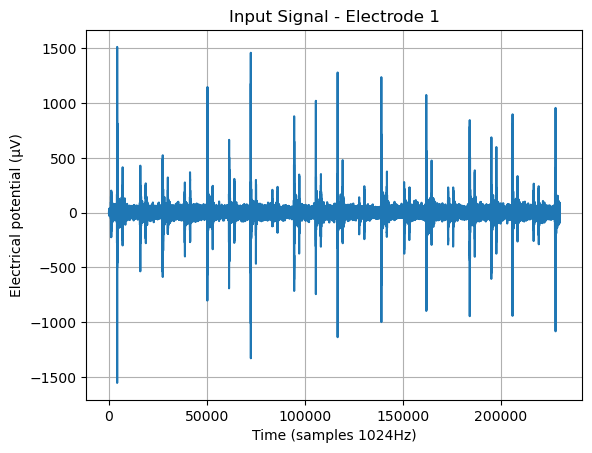

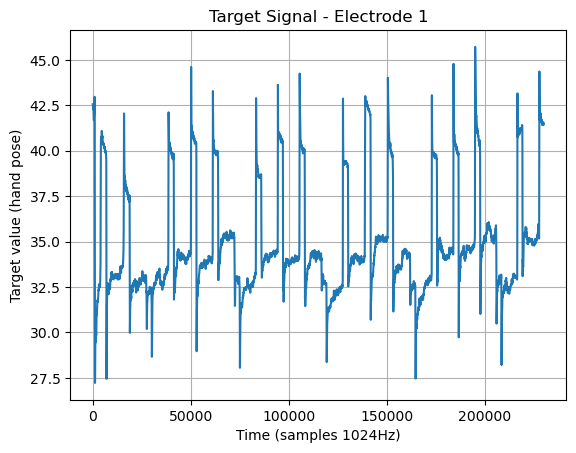

In [21]:
import matplotlib.pyplot as plt

# Plot first EMG signal (e.g. from channel 0)
plt.plot(guided_dataset_X[0, 0, :])
plt.title("Input Signal - Electrode 1")
plt.xlabel("Time (samples 1024Hz)")
plt.ylabel("Electrical potential (μV)")
plt.grid(True)
plt.show()

# Plot corresponding output/target signal
plt.figure()
plt.plot(guided_dataset_y[0, 0, :])
plt.title("Target Signal - Electrode 1")
plt.xlabel("Time (samples 1024Hz)")
plt.ylabel("Target value (hand pose)")
plt.grid(True)
plt.show()


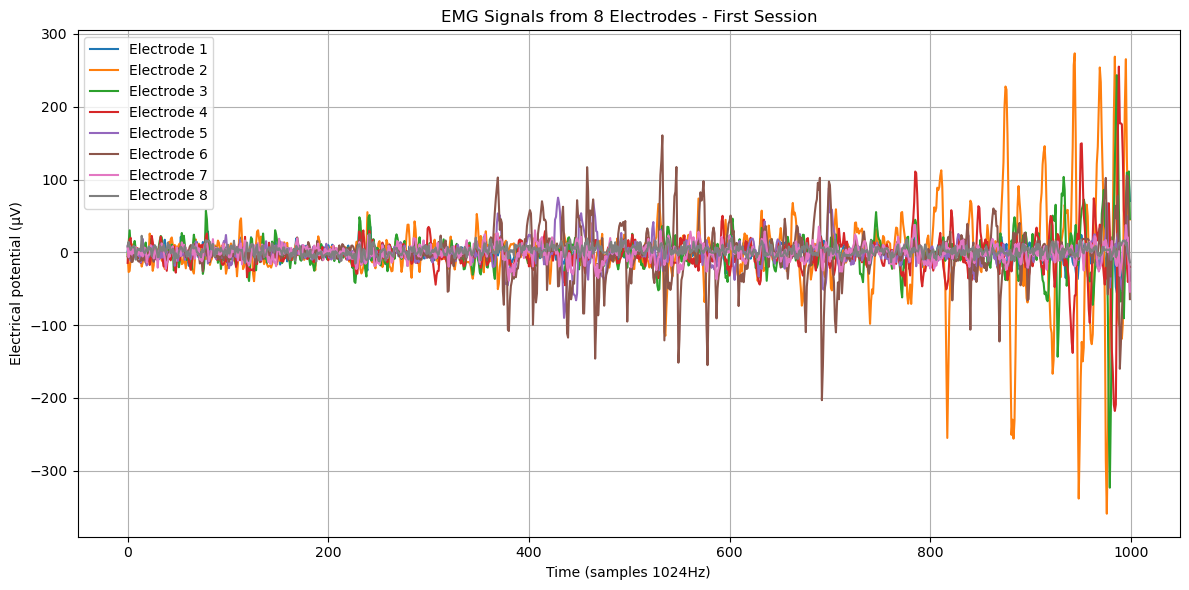

In [5]:
# Plot EMG signals from 8 electrodes (first session)
fig, ax = plt.subplots(figsize=(12, 6))  # Un seul subplot

for i in range(8):
    ax.plot(guided_dataset_X[0, i, :1000], label=f'Electrode {i+1}') #Fixed time sample of 1000 hz

ax.set_title('EMG Signals from 8 Electrodes - First Session')
ax.set_xlabel('Time (samples 1024Hz)')
ax.set_ylabel('Electrical potential (μV)')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()
plt.show()


We can't really see any useful informations from this data directly. Except that we can see some electrode divergence according to Electrical potential and time.

## 1. Data Preparation
- 1.1 Signal filtering *(optional)*


We tried to use apply a fourier corriction to filter the signal (objective 1). Indeed, it usual to use this type of transformations to filter non-periodic fonctions.
However the results were not convincing and we chose not to use this filtering.

- 1.2 Sliding window creation with overlap


The following cell must be changed based on the data we want to work on

In [6]:
X = guided_dataset_X
y = guided_dataset_y

Based on the instructions we had to create a sliding window with overlap (objective 2)

In [7]:
window_size = 500 # 500 ms window
overlap = 250 # 50% overlap
n_windows = (X.shape[2]-window_size)//overlap + 1 #Windows have overlap over next windows
X_windowed = np.zeros((X.shape[0], X.shape[1], n_windows, window_size))
y_windowed = np.zeros((y.shape[0], y.shape[1], n_windows))
for i in range(n_windows): 
    X_windowed[:,:,i,:] = X[:,:,(i*overlap):(i*overlap+window_size)]
    y_windowed[:,:,i] = y[:,:,i*overlap+window_size-1]

print("Shape of windowed X:", X_windowed.shape)# 5 sessions, 8 electrodes, 919 windows, 500 time points
print("Shape of windowed y:", y_windowed.shape)

Shape of windowed X: (5, 8, 919, 500)
Shape of windowed y: (5, 51, 919)


## 2. Cross-Validation
- 2.1 Cross-validation strategy


In [8]:
# Training and validation split.
def train_val_split(X, y, session_num):
    """
    Splits the data into training and validation sets based on the session number.
    The training set consists of all sessions except the specified session number,
    and the validation set consists of the specified session number.
    """
    # Select the session number for validation
    sessions = [0, 1, 2, 3, 4]
    train_sessions = [s for s in sessions if s != session_num]
    # Create the training and validation sets
    X_train = np.stack(X[train_sessions,:,:,:])
    y_train = np.stack(y[train_sessions,:,:])
    X_val = X[session_num,:,:,:]
    y_val = y[session_num,:,:]

    # Stack the data for training and validation
    X_train_stacked = X_train.transpose(1,0,2,3).reshape(X_train.shape[1], -1, window_size)
    y_train_stacked = y_train.transpose(1,0,2).reshape(y_train.shape[1], -1)
    X_train_stacked = X_train_stacked.transpose(1,0,2)
    y_train_stacked = y_train_stacked.transpose(1,0)

    X_val_stacked = X_val.transpose(1,0,2)
    y_val_stacked = y_val.transpose(1,0)

    return X_train_stacked, y_train_stacked, X_val_stacked, y_val_stacked


41.695092762519344


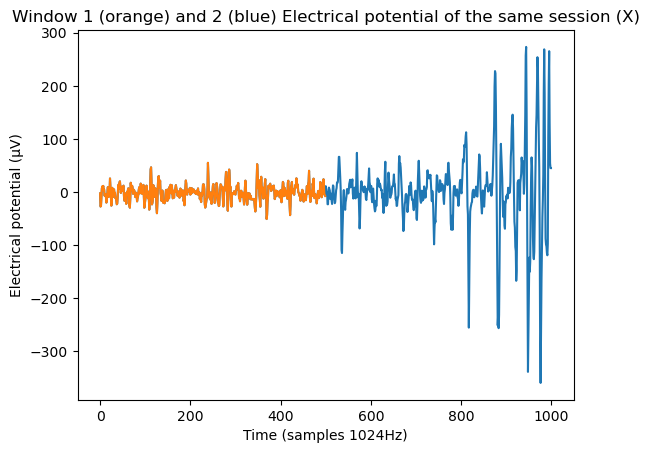

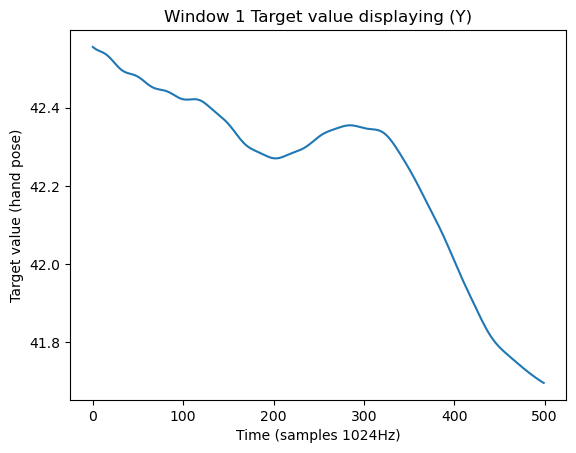

In [24]:
# Example usage
X_train_stacked, y_train_stacked, X_val_stacked, y_val_stacked = train_val_split(X_windowed, y_windowed, 4)

plt.plot(X[0,1,0:1000])
plt.title("Window 1 (orange) and 2 (blue) Electrical potential of the same session (X)")
plt.xlabel("Time (samples 1024Hz)")
plt.ylabel("Electrical potential (μV)")
plt.plot(np.arange(0, 500),X_train_stacked[0,1,:])
plt.figure()
plt.title("Window 1 Target value displaying (Y)")
plt.xlabel("Time (samples 1024Hz)")
plt.ylabel("Target value (hand pose)")
plt.plot(y[0,0,0:500])
print(y_train_stacked[0,0])

For our regression task, we implement a **nested cross-validation strategy**:

##### Outer Loop: Leave-One-Session-Out CV
- Each of the 5 recording sessions serves once as a validation set
- The remaining 4 sessions are used for training
- This approach evaluates generalization across different recording conditions

##### Inner Loop: Parameter Tuning and feature selection
- Within each fold of the outer loop, we use the 4 training sessions to optimize hyperparameters
- Grid search with k-fold cross-validation on these 4 sessions identifies optimal model configurations
- This prevents information leakage between hyperparameter selection and model evaluation

This nested approach ensures that:
1. Model selection occurs independently from final performance evaluation
2. Reported metrics represent true generalization ability to unseen sessions
3. Hyperparameters are optimized without contaminating validation results

- 2.2 Justification and prevention of *data leakage*



This validation method:
- **Prevents data leakage**: Our validation sets remain completely independent from the training set. Indeed, the data split is done at the session level, before any windowing. Each session is segmented into overlapping frames only after assigning it to either train or validation. Plus, this guarantees that no overlapping signal segments are shared between training and validation sets, avoiding any data leakage.

- **Ensure reliability and generalizability of your model performance estimates**: By validating on entirely unseen sessions, our evaluation reflects the model’s ability to generalize to data coming from new sessions of the same individual. It also avoids overfitting to intra-session noise or redundancy that could arise from overlapping frames.

## 3. Baseline Approach
- 3.1 Implementation of time-based feature extractor


We create a custom class from scikit-learn BaseEstimator and TransformerMixin that implements the extraction of common time-domain features

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline

class CommonFeaturesTransformer(BaseEstimator, TransformerMixin):
    """
    Custom transformer that extract common features from the data.
    """
    def __init__(self, sigma):
        self.sigma = sigma

    # Mean Absolute Value (MAV)
    def MAV(self, X):
        return np.mean(np.abs(X),axis = 2)
    
    # Root Mean Square (RMS)
    def RMS(self, X):
        return np.mean(X*X,axis = 2)

    # Variance (VAR)
    def Var(self, X):
        return np.var(X,axis = 2,ddof=1)
    
    # Standard Deviation (STD)
    def STD(self, X):
        return np.sqrt(self.Var(X))
    
    # Zero Crossing (ZC)
    def ZC(self, X):
        return np.sum(X[:,:,0:499]*X[:,:,1:500]<0,axis = 2)
    
    # Myopulse percentage rate (MPR)
    def MPR(self, X):
        return np.mean(np.abs(X)>self.sigma,axis = 2)
    
    ############################################
    #Non mentionned features in the instructions:
    ############################################

    # Maximum absolute amplitude (MAA)
    def MAA(self, X):
        return np.max(np.abs(X),axis = 2)
    
    # Waveform length (WL)
    def WL(self, X):
        return np.sum(np.abs(X[:,:,1:500]-X[:,:,0:499]),axis = 2)
    
    # Slope sign changes (SSC)
    def SSC(self, X):
        return np.sum(np.abs((X[:,:,2:500]-X[:,:,1:499])*(X[:,:,1:499]-X[:,:,0:498]))<0,axis = 2)
    
    # Wilson amplitude (WA)
    # ???

    # Maximum fractal length (MFL)
    def MFL(self, X):
        return np.log(np.sqrt(np.sum((X[:,:,1:500]-X[:,:,0:499])**2,axis = 2)))
    
    # Kurtosis (KUR)
    # ???
    
    # ?
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        features = np.stack([self.MAV(X),self.RMS(X),self.Var(X),self.STD(X),self.ZC(X),self.MPR(X),
                               self.MAA(X),self.WL(X),self.SSC(X),self.MFL(X)],axis = 2)
        res = features.reshape(features.shape[0],-1)
        return res

- 3.2 Performance metrics

RMSE measures the mean absolute value of the error between predictions and real values taking account of dimmensions (Here D=51). RMSE keeps the measure unitys (degrees here)

NMSE then normalizes this error using the true values variance. We can then compare the quality of the predictions without caring about the data scale. 

The more those metrics are low, the more the predictions follow the real model. 

In [11]:
# Normalized Mean Square Error (NMSE) and Root Mean Square Error (RMSE) functions
def NMSE(y_true, y_pred):
    return np.sum((y_pred-y_true)**2)/np.sum((np.mean(y_true,axis = 0)-y_true)**2)

def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_pred-y_true)**2))

- 3.3.a DummyRegressor as baseline

In [12]:
from sklearn.dummy import DummyRegressor

custom_pipeline = Pipeline([
    ("custom_features", CommonFeaturesTransformer(sigma = 200)),
    ("scaler", StandardScaler()),
    ("regressor", DummyRegressor(strategy="mean"))
])
from tqdm import tqdm

def fit_and_evaluate_model(X_windowed, y_windowed, model):
    """
    Fits the model to the training data and evaluates it on the validation data.
    """
    # Leave-one-session-out cross-validation
    nmse_list = []
    rmse_list = []
    for session in tqdm(range(5)):
        # Train and validate the model on the current session
        X_train, y_train, X_val, y_val = train_val_split(X_windowed, y_windowed, session)
        # Fit the model
        model.fit(X_train, y_train)
        # Predict on the test set
        y_pred = model.predict(X_val)
        # Calculate NMSE and RMSE
        nmse_list.append(NMSE(y_val, y_pred))
        rmse_list.append(RMSE(y_val, y_pred))

    return nmse_list, rmse_list

# Fit and evaluate the model
nmse_list, rmse_list = fit_and_evaluate_model(X_windowed, y_windowed, custom_pipeline)

# Print the NMSE and RMSE for each session
for session in range(5):
    print("Session", session, "- NMSE:", round(nmse_list[session], 2), "| RMSE:", round(rmse_list[session], 2),"\n")

# Calculate the mean NMSE and RMSE across all sessions
mean_nmse = np.mean(nmse_list)
mean_rmse = np.mean(rmse_list)
print("NMSE:", round(mean_nmse, 2), "+-", round(np.std(nmse_list), 3))
print("RMSE:", round(mean_rmse, 2), "+-", round(np.std(rmse_list), 3))

100%|█████████████████████████████████████████████| 5/5 [00:03<00:00,  1.59it/s]

Session 0 - NMSE: 1.01 | RMSE: 14.01 

Session 1 - NMSE: 1.01 | RMSE: 14.06 

Session 2 - NMSE: 1.0 | RMSE: 14.63 

Session 3 - NMSE: 1.0 | RMSE: 14.07 

Session 4 - NMSE: 1.0 | RMSE: 14.52 

NMSE: 1.01 +- 0.004
RMSE: 14.26 +- 0.261


- 3.4 First model: Linear regression


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.20it/s]


Session 0 - NMSE: 0.32 | RMSE: 7.91 

Session 1 - NMSE: 0.24 | RMSE: 6.86 

Session 2 - NMSE: 0.21 | RMSE: 6.66 

Session 3 - NMSE: 0.18 | RMSE: 6.0 

Session 4 - NMSE: 0.18 | RMSE: 6.21 

NMSE: 0.23 +- 0.052
RMSE: 6.73 +- 0.666
['MAV_1', 'RMS_1', 'Var_1', 'STD_1', 'ZC_1', 'MPR_1', 'MAA_1', 'WL_1', 'SSC_1', 'MFL_1', 'MAV_2', 'RMS_2', 'Var_2', 'STD_2', 'ZC_2', 'MPR_2', 'MAA_2', 'WL_2', 'SSC_2', 'MFL_2', 'MAV_3', 'RMS_3', 'Var_3', 'STD_3', 'ZC_3', 'MPR_3', 'MAA_3', 'WL_3', 'SSC_3', 'MFL_3', 'MAV_4', 'RMS_4', 'Var_4', 'STD_4', 'ZC_4', 'MPR_4', 'MAA_4', 'WL_4', 'SSC_4', 'MFL_4', 'MAV_5', 'RMS_5', 'Var_5', 'STD_5', 'ZC_5', 'MPR_5', 'MAA_5', 'WL_5', 'SSC_5', 'MFL_5', 'MAV_6', 'RMS_6', 'Var_6', 'STD_6', 'ZC_6', 'MPR_6', 'MAA_6', 'WL_6', 'SSC_6', 'MFL_6', 'MAV_7', 'RMS_7', 'Var_7', 'STD_7', 'ZC_7', 'MPR_7', 'MAA_7', 'WL_7', 'SSC_7', 'MFL_7', 'MAV_8', 'RMS_8', 'Var_8', 'STD_8', 'ZC_8', 'MPR_8', 'MAA_8', 'WL_8', 'SSC_8', 'MFL_8']


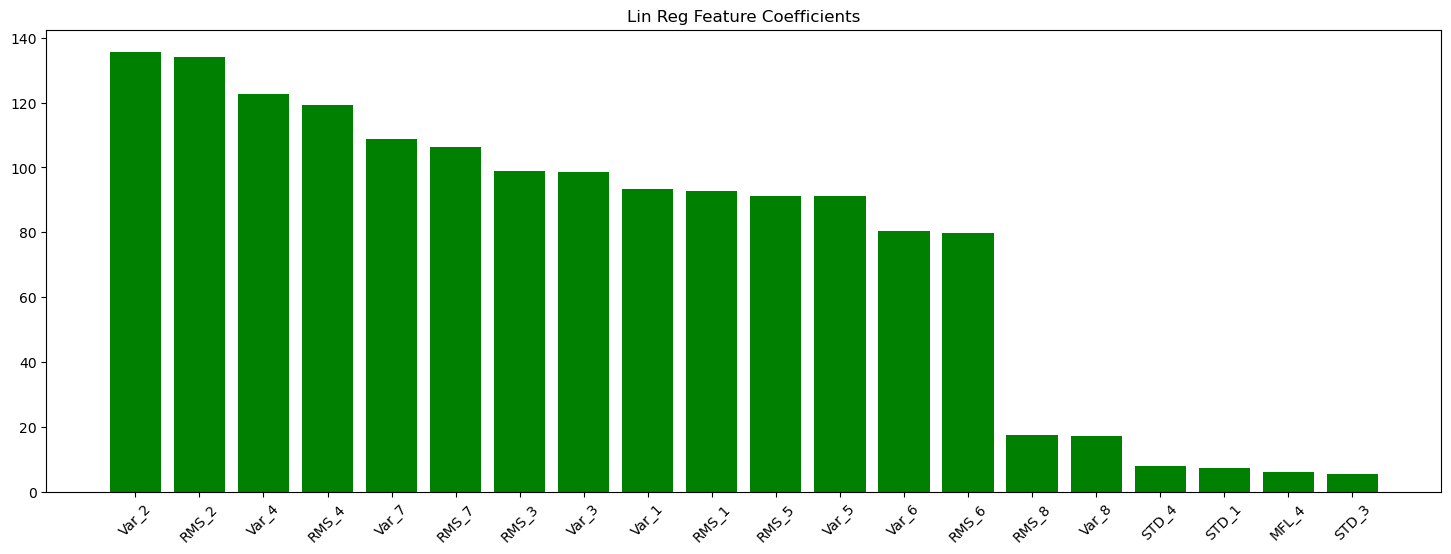

In [13]:
custom_pipeline = Pipeline([
    ("custom_features", CommonFeaturesTransformer(sigma = 200)),
    ("scaler", StandardScaler()),
    ("regressor", LinearRegression())
])
# Fit and evaluate the model
nmse_list, rmse_list = fit_and_evaluate_model(X_windowed, y_windowed, custom_pipeline)

# Print the NMSE and RMSE for each session
for session in range(5):
    print("Session", session, "- NMSE:", round(nmse_list[session], 2), "| RMSE:", round(rmse_list[session], 2),"\n")

# Calculate the mean NMSE and RMSE across all sessions
mean_nmse = np.mean(nmse_list)
mean_rmse = np.mean(rmse_list)
print("NMSE:", round(mean_nmse, 2), "+-", round(np.std(nmse_list), 3))
print("RMSE:", round(mean_rmse, 2), "+-", round(np.std(rmse_list), 3))

feature_names = []
feature_types = ["MAV", "RMS", "Var", "STD", "ZC", "MPR", "MAA", "WL", "SSC", "MFL"]
channels = range(1, 9)

for ch in channels:
    for feat in feature_types:
        feature_names.append(f"{feat}_{ch}")
print(feature_names)

X_train, y_train, X_val, y_val = train_val_split(X_windowed, y_windowed, 4)

t = CommonFeaturesTransformer(sigma = 200)
X_t = t.transform(X_train)

coefs = custom_pipeline.named_steps["regressor"].coef_
coefs = np.mean(np.abs(coefs), axis=0)
coefs_sorted_idx = np.argsort(coefs)[::-1]

sorted_feature_names = []
for i in coefs_sorted_idx:
    sorted_feature_names.append(feature_names[i])

plt.figure(figsize=(18, 6))
plt.title("Lin Reg Feature Coefficients")
plt.bar(range(20), coefs[coefs_sorted_idx][:20], align='center', color='green')
plt.xticks(range(20), sorted_feature_names[:20], rotation=45)
plt.show()

- 3.5. Second model: Ridge regression

  0%|                                                    | 0/40 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 40/40 [03:47<00:00,  5.70s/it]


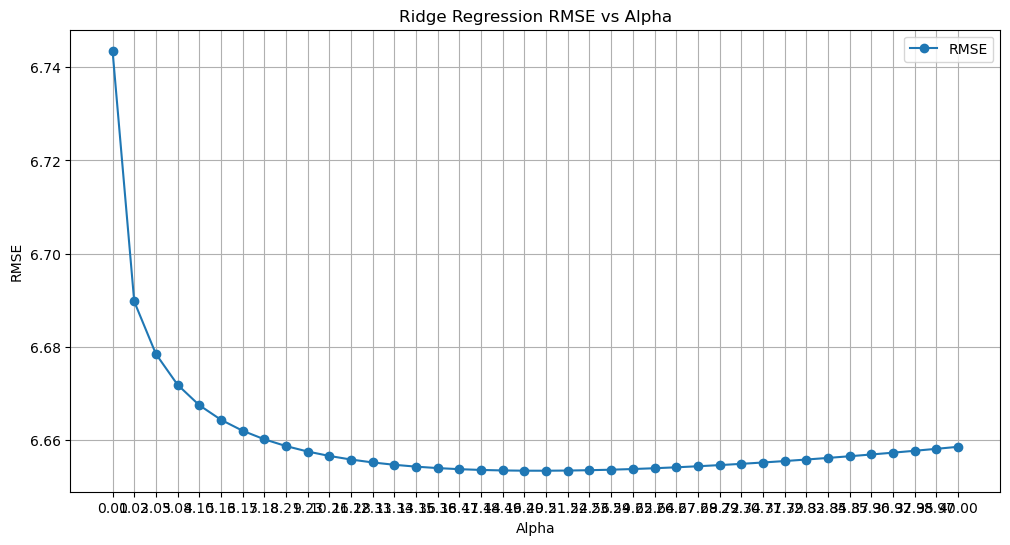

Best alpha for RMSE: 20.51282051282051
Best RMSE: 6.653385707889727
Best NMSE: 0.2225460769601016


In [14]:
from tqdm import tqdm

alphas = np.linspace(0, 40, 40)

RMSE_list_ridge = []
NMSE_list_ridge = []
for alpha in tqdm(alphas):
    custom_pipeline = Pipeline([
        ("custom_features", CommonFeaturesTransformer(sigma = 200)),
        ("scaler", StandardScaler()),
        ("regressor", Ridge(alpha=alpha))
    ])

    # Fit and evaluate the model
    nmse_list, rmse_list = fit_and_evaluate_model(X_windowed, y_windowed, custom_pipeline)

    # Calculate the mean NMSE and RMSE across all sessions
    RMSE_list_ridge.append(np.mean(rmse_list))
    NMSE_list_ridge.append(np.mean(nmse_list))

plt.figure(figsize=(12, 6))
plt.title("Ridge Regression RMSE vs Alpha")
plt.plot(alphas, RMSE_list_ridge, marker='o', label='RMSE')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.xticks(alphas)
plt.grid()
plt.legend()
plt.show()

best_alpha = alphas[np.argmin(RMSE_list_ridge)]
print("Best alpha for RMSE:", best_alpha)
print("Best RMSE:", np.min(RMSE_list_ridge))
print("Best NMSE:", NMSE_list_ridge[np.argmin(RMSE_list_ridge)])

100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.08s/it]


Session 0 - NMSE: 0.32 | RMSE: 7.94 

Session 1 - NMSE: 0.23 | RMSE: 6.72 

Session 2 - NMSE: 0.2 | RMSE: 6.52 

Session 3 - NMSE: 0.18 | RMSE: 5.88 

Session 4 - NMSE: 0.18 | RMSE: 6.21 

NMSE: 0.22 +- 0.054
RMSE: 6.65 +- 0.702
['MAV_1', 'RMS_1', 'Var_1', 'STD_1', 'ZC_1', 'MPR_1', 'MAA_1', 'WL_1', 'SSC_1', 'MFL_1', 'MAV_2', 'RMS_2', 'Var_2', 'STD_2', 'ZC_2', 'MPR_2', 'MAA_2', 'WL_2', 'SSC_2', 'MFL_2', 'MAV_3', 'RMS_3', 'Var_3', 'STD_3', 'ZC_3', 'MPR_3', 'MAA_3', 'WL_3', 'SSC_3', 'MFL_3', 'MAV_4', 'RMS_4', 'Var_4', 'STD_4', 'ZC_4', 'MPR_4', 'MAA_4', 'WL_4', 'SSC_4', 'MFL_4', 'MAV_5', 'RMS_5', 'Var_5', 'STD_5', 'ZC_5', 'MPR_5', 'MAA_5', 'WL_5', 'SSC_5', 'MFL_5', 'MAV_6', 'RMS_6', 'Var_6', 'STD_6', 'ZC_6', 'MPR_6', 'MAA_6', 'WL_6', 'SSC_6', 'MFL_6', 'MAV_7', 'RMS_7', 'Var_7', 'STD_7', 'ZC_7', 'MPR_7', 'MAA_7', 'WL_7', 'SSC_7', 'MFL_7', 'MAV_8', 'RMS_8', 'Var_8', 'STD_8', 'ZC_8', 'MPR_8', 'MAA_8', 'WL_8', 'SSC_8', 'MFL_8']


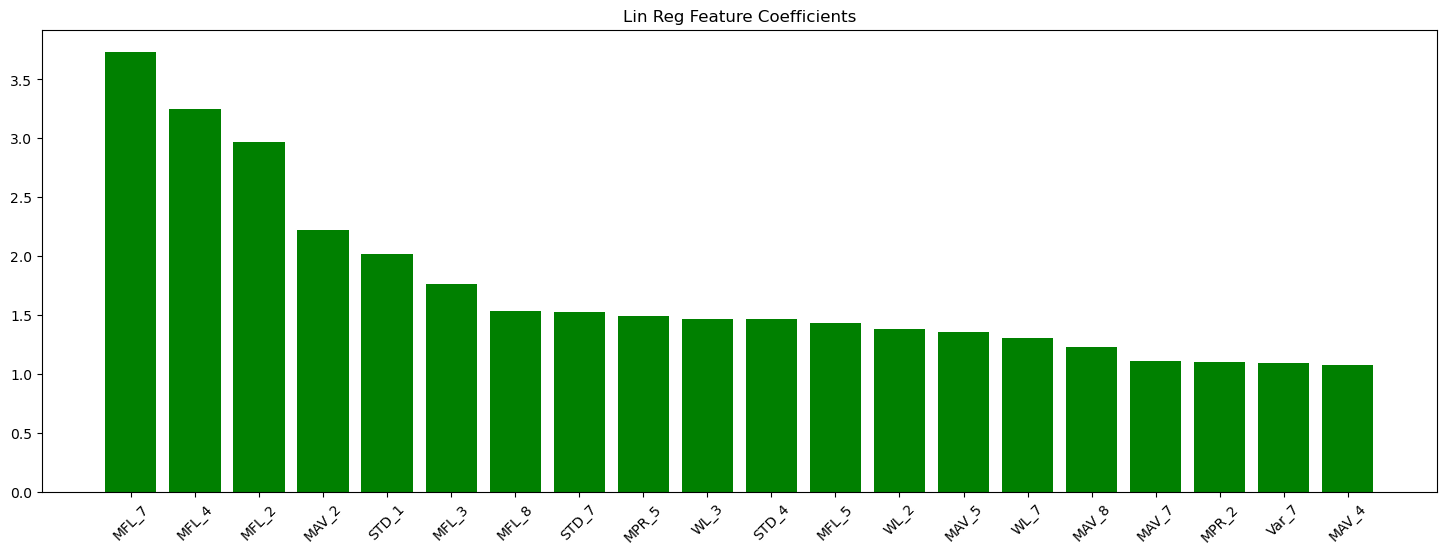

In [15]:
# Fit the model with the best alpha
custom_pipeline = Pipeline([
        ("custom_features", CommonFeaturesTransformer(sigma = 200)),
        ("scaler", StandardScaler()),
        ("regressor", Ridge(alpha=best_alpha))
    ])

# Fit and evaluate the model
nmse_list, rmse_list = fit_and_evaluate_model(X_windowed, y_windowed, custom_pipeline)

# Print the NMSE and RMSE for each session
for session in range(5):
    print("Session", session, "- NMSE:", round(nmse_list[session], 2), "| RMSE:", round(rmse_list[session], 2),"\n")

# Calculate the mean NMSE and RMSE across all sessions
mean_nmse = np.mean(nmse_list)
mean_rmse = np.mean(rmse_list)
print("NMSE:", round(mean_nmse, 2), "+-", round(np.std(nmse_list), 3))
print("RMSE:", round(mean_rmse, 2), "+-", round(np.std(rmse_list), 3))

# Feature importance analysis
feature_names = []
feature_types = ["MAV", "RMS", "Var", "STD", "ZC", "MPR", "MAA", "WL", "SSC", "MFL"]
channels = range(1, 9)

for ch in channels:
    for feat in feature_types:
        feature_names.append(f"{feat}_{ch}")
print(feature_names)

t = CommonFeaturesTransformer(sigma = 200)
X_t = t.transform(X_train)

coefs = custom_pipeline.named_steps["regressor"].coef_
coefs = np.mean(np.abs(coefs), axis=0)
coefs_sorted_idx = np.argsort(coefs)[::-1]

sorted_feature_names = []
for i in coefs_sorted_idx:
    sorted_feature_names.append(feature_names[i])

plt.figure(figsize=(18, 6))
plt.title("Lin Reg Feature Coefficients")
plt.bar(range(20), coefs[coefs_sorted_idx][:20], align='center', color='green')
plt.xticks(range(20), sorted_feature_names[:20], rotation=45)
plt.show()

- 3.6. Third model: PolynomialFeatures + Ridge Regression

100%|████████████████████████████████████████████| 1/1 [06:07<00:00, 367.60s/it]


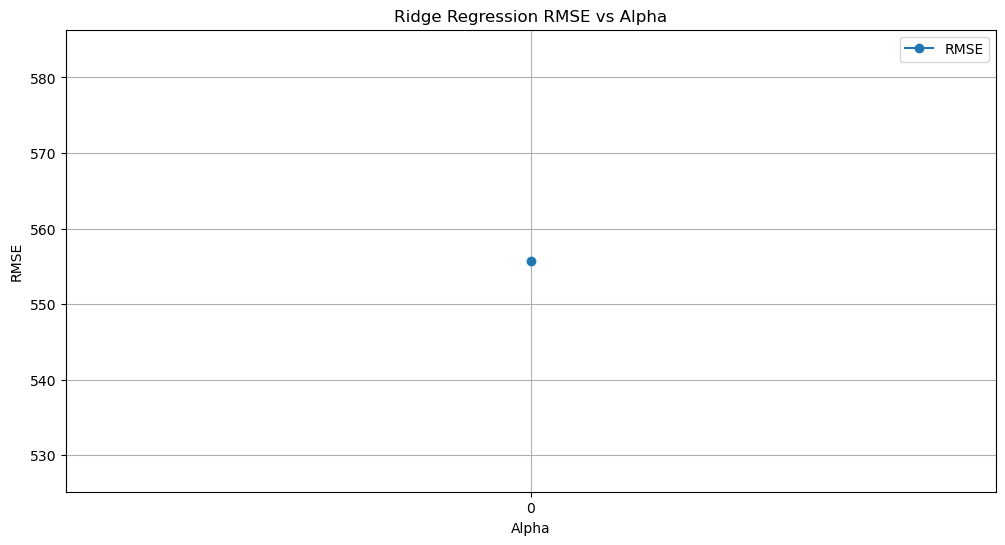

Best alpha for RMSE: 0
Best RMSE: 555.7534027193527
Best NMSE: 1601.337345378761


In [16]:
from tqdm import tqdm
alphas = [0]

RMSE_list_ridge = []
NMSE_list_ridge = []
for alpha in tqdm(alphas):
    custom_pipeline = Pipeline([
    ("custom_features", CommonFeaturesTransformer(sigma = 200)),
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("regressor", Ridge(alpha=alpha, fit_intercept=True))
    ])

    # Leave-one-session-out cross-validation
    nmse_list = []
    rmse_list = []
    for session in range(5):
        # Train and validate the model on the current session
        X_train, y_train, X_test, y_test = train_val_split(X_windowed, y_windowed, session)
        # Fit the model
        custom_pipeline.fit(X_train, y_train)
        # Predict on the test set
        y_pred = custom_pipeline.predict(X_test)
        # Calculate NMSE and RMSE
        nmse_list.append(NMSE(y_test, y_pred))
        rmse_list.append(RMSE(y_test, y_pred))

    # Calculate the mean NMSE and RMSE across all sessions
    RMSE_list_ridge.append(np.mean(rmse_list))
    NMSE_list_ridge.append(np.mean(nmse_list))

plt.figure(figsize=(12, 6))
plt.title("Ridge Regression RMSE vs Alpha")
plt.plot(alphas, RMSE_list_ridge, marker='o', label='RMSE')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.xticks(alphas)
plt.grid()
plt.legend()
plt.show()

best_alpha = alphas[np.argmin(RMSE_list_ridge)]
print("Best alpha for RMSE:", best_alpha)
print("Best RMSE:", np.min(RMSE_list_ridge))
print("Best NMSE:", NMSE_list_ridge[np.argmin(RMSE_list_ridge)])

['SSC_2 RMS_4', 'SSC_4 MPR_7', 'SSC_2 MFL_3', 'SSC_5 RMS_7', 'SSC_2 MAA_5', 'SSC_3 MAA_7', 'SSC_1 WL_3', 'SSC_7 WL_8', 'Var_3 SSC_4', 'SSC_1 MPR_2', 'MAV_1 SSC_5', 'SSC_6 STD_7', 'MAA_3 SSC_4', 'Var_1 SSC_4', 'SSC_4^2', 'ZC_3 SSC_3', 'SSC_1 ZC_7', 'SSC_1 ZC_3', 'SSC_6 WL_7', 'SSC_4 WL_5', 'SSC_6 SSC_7', 'MFL_4 SSC_6', 'MPR_7 SSC_7', 'RMS_1 SSC_2', 'STD_1 SSC_7', 'MFL_3 SSC_7', 'SSC_2 ZC_7', 'MAV_1 SSC_4', 'SSC_1 SSC_7', 'SSC_6 RMS_8', 'SSC_2 MPR_4', 'Var_2 SSC_2', 'WL_1 SSC_2', 'RMS_4 SSC_5', 'ZC_2 SSC_2', 'SSC_2 MAA_3', 'MAA_6 SSC_6', 'SSC_1 MFL_2', 'Var_2 SSC_3', 'SSC_1', 'ZC_1 SSC_6', 'SSC_1 MAV_3', 'STD_6 SSC_7', 'SSC_2 RMS_3', 'WL_3 SSC_5', 'SSC_4 MAA_5', 'ZC_3 SSC_4', 'SSC_3 MFL_4', 'MFL_2 SSC_8', 'SSC_3 STD_5', 'SSC_4 STD_5', 'SSC_5 MAV_8', 'MAV_5 SSC_8', 'SSC_1 WL_2', 'SSC_1 MPR_3', 'STD_7 SSC_7', 'Var_2 SSC_8', 'SSC_3 SSC_7', 'SSC_5 MPR_8', 'MPR_5 SSC_5', 'SSC_6 MAA_8', 'SSC_2 STD_3', 'SSC_4 Var_7', 'ZC_2 SSC_7', 'SSC_4 MPR_8', 'SSC_1 STD_6', 'SSC_1 MAA_4', 'MAV_2 SSC_5', 'MAV

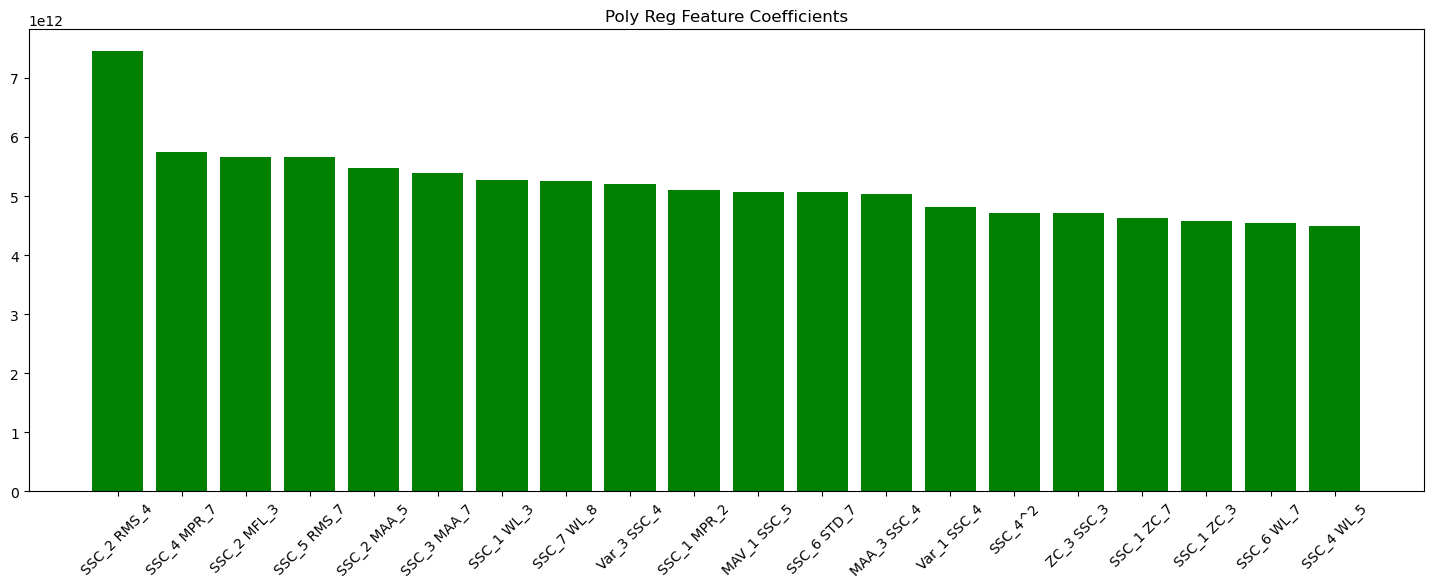

In [17]:
# Extracting the coefficients of the polynomial regression model
t = CommonFeaturesTransformer(sigma = 200)
X_t = t.transform(X_train_stacked)
poly = custom_pipeline.named_steps["poly"]
X_poly = poly.transform(X_t)
coefs = custom_pipeline.named_steps["regressor"].coef_
coefs = np.mean(np.abs(coefs), axis=0)
coefs_sorted_idx = np.argsort(coefs)[::-1]
sorted_feature_names = []
feature_names_poly = poly.get_feature_names_out(feature_names)
for i in coefs_sorted_idx:
    sorted_feature_names.append(feature_names_poly[i])
print(sorted_feature_names)
plt.figure(figsize=(18, 6))
plt.title("Poly Reg Feature Coefficients")
plt.bar(range(20), coefs[coefs_sorted_idx][:20], align='center', color='green')
plt.xticks(range(20), sorted_feature_names[:20], rotation=45)
plt.show()


- 3.7. Fourth model: Random Forest

In [18]:
from sklearn.ensemble import RandomForestRegressor

custom_pipeline = Pipeline([
    ("custom_features", CommonFeaturesTransformer(sigma = 500)),
    ("scaler", StandardScaler()),
    ("regressor", RandomForestRegressor(n_estimators=200, random_state=42))
])

# Fit and evaluate the model
nmse_list, rmse_list = fit_and_evaluate_model(X_windowed, y_windowed, custom_pipeline)

# Print the NMSE and RMSE for each session
for session in range(5):
    print("Session", session, "- NMSE:", round(nmse_list[session], 2), "| RMSE:", round(rmse_list[session], 2),"\n")

# Calculate the mean NMSE and RMSE across all sessions
mean_nmse = np.mean(nmse_list)
mean_rmse = np.mean(rmse_list)
print("NMSE:", round(mean_nmse, 2), "+-", round(np.std(nmse_list), 3))
print("RMSE:", round(mean_rmse, 2), "+-", round(np.std(rmse_list), 3))

100%|█████████████████████████████████████████████| 5/5 [08:00<00:00, 96.13s/it]

Session 0 - NMSE: 0.22 | RMSE: 6.57 

Session 1 - NMSE: 0.09 | RMSE: 4.18 

Session 2 - NMSE: 0.12 | RMSE: 5.05 

Session 3 - NMSE: 0.08 | RMSE: 3.85 

Session 4 - NMSE: 0.08 | RMSE: 3.98 

NMSE: 0.12 +- 0.056
RMSE: 4.73 +- 1.014


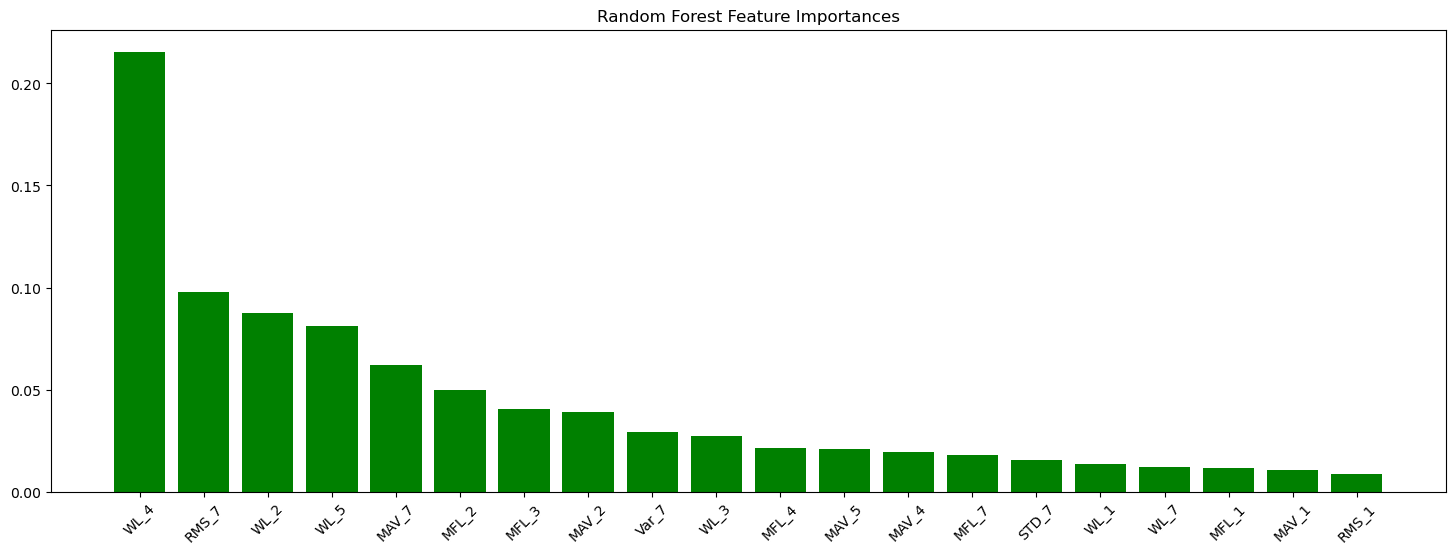

In [19]:
forest_importances = custom_pipeline.named_steps["regressor"].feature_importances_
forest_sorted_idx = np.argsort(forest_importances)[::-1]

sorted_feature_names = []
for i in forest_sorted_idx:
    sorted_feature_names.append(feature_names[i])
    
plt.figure(figsize=(18, 6))
plt.title("Random Forest Feature Importances")
plt.bar(range(20), forest_importances[forest_sorted_idx][:20], align='center', color='green')
plt.xticks(range(20), sorted_feature_names[:20], rotation=45)
plt.show()

- 3.8. Fifth model: KNN regressor

In [20]:
from sklearn.neighbors import KNeighborsRegressor
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

RMSE_list_knn = []
NMSE_list_knn = []
for k in tqdm(k_values):
    custom_pipeline = Pipeline([
        ("custom_features", CommonFeaturesTransformer(sigma = 200)),
        ("scaler", StandardScaler()),
        ("regressor", KNeighborsRegressor(n_neighbors=k))
    ])

    # Fit and evaluate the model
    nmse_list, rmse_list = fit_and_evaluate_model(X_windowed, y_windowed, custom_pipeline)

    # Calculate the mean NMSE and RMSE across all sessions
    RMSE_list_knn.append(np.mean(rmse_list))
    NMSE_list_knn.append(np.mean(nmse_list))

plt.figure(figsize=(12, 6))
plt.title("KNN RMSE vs k")
plt.plot(k_values, RMSE_list_knn, marker='o', label='RMSE')
plt.xlabel('k')
plt.ylabel('RMSE')
plt.xticks(k_values)
plt.grid()
plt.legend()
plt.show()

best_k = k_values[np.argmin(RMSE_list_knn)]
print("Best alpha for RMSE:", best_k)
print("Best RMSE:", np.min(RMSE_list_knn))
print("Best NMSE:", NMSE_list_knn[np.argmin(RMSE_list_knn)])

  0%|                                                    | 0/10 [00:00<?, ?it/s]


AttributeError: 'NoneType' object has no attribute 'split'

## 4. Advanced Approach

In [ ]:
class FullFeaturesTransformer(BaseEstimator, TransformerMixin):
    """
    Custom transformer that extract all features. A VOIR
    """
    def __init__(self, sigma):
        self.sigma = sigma

    def MAV(self, X):
        return np.mean(np.abs(X),axis = 2)
    
    def RMS(self, X):
        return np.mean(X*X,axis = 2)

    def Var(self, X):
        return np.var(X,axis = 2,ddof=1)
        
    def STD(self, X):
        return np.sqrt(self.Var(X))
        
    def ZC(self, X):
        return np.sum(X[:,:,0:499]*X[:,:,1:500]<0,axis = 2)
        
    def MPR(self, X):
        return np.mean(np.abs(X)>self.sigma,axis = 2)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        features = np.stack([self.MAV(X),self.RMS(X),self.Var(X),self.STD(X),self.ZC(X),self.MPR(X)],axis = 2)
        res = features.reshape(features.shape[0],-1)
        return res

In [ ]:
print(X_train_stacked.shape)
print(y_train_stacked.shape)

X_train_torch = X_train_stacked.reshape(-1, 1, X_train_stacked.shape[1], X_train_stacked.shape[2])
X_train_torch = torch.from_numpy(X_train_torch).float().to(device)

y_train_torch = torch.from_numpy(y_train_stacked).float().to(device)

X_test_torch = X_test_stacked.reshape(-1, 1, X_test_stacked.shape[1], X_test_stacked.shape[2])
X_test_torch = torch.from_numpy(X_test_torch).float().to(device)
y_test_torch = torch.from_numpy(y_test_stacked).float().to(device)


In [ ]:
# This CNN will perform a regression task (e.g., predicting a real-valued output from an image).
# We'll use two convolution layers (with 2x2 max pooling after each), then two fully-connected layers,
# include dropout with probability=0.25, and weight decay in the optimizer for regularization.
class ShallowConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 40, (1, 13), bias=False)
        self.conv2 = nn.Conv2d(40, 40, (8, 1), bias=False)
        self.Bn1   = nn.BatchNorm2d(40)
        self.AvgPool1 = nn.AvgPool2d((1, 35), stride=(1, 7))
        self.Drop1 = nn.Dropout(0.25)
        self.classifier = nn.Linear(40*65, 51, bias=True)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.Bn1(x)
        x = x ** 2
        x = self.AvgPool1(x)
        x = torch.log(x)
        x = self.Drop1(x)
        x = x.view(-1, 40*65)
        x = self.classifier(x)
        
        return x



# We'll wrap the data in TensorDatasets and DataLoaders for batching
train_dataset = TensorDataset(X_train_torch, y_train_torch)
val_dataset   = TensorDataset(X_test_torch, y_test_torch)

train_loader  = DataLoader(train_dataset, batch_size=50, shuffle=True)
val_loader    = DataLoader(val_dataset, batch_size=50, shuffle=False)

# Instantiate our CNN model
model = ShallowConvNet().to(device)

# We'll use MSELoss for this regression task
criterion = nn.MSELoss()

# We'll use Adam optimizer with weight decay for L2 regularization
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Setup for training with early stopping
max_epochs         = 150
patience           = 20  # number of epochs with no improvement allowed
best_val_loss      = float('inf')
epochs_no_improve  = 0
best_model_path    = "best_model.pth"

for epoch in range(max_epochs):
    # Train mode: enables dropout, etc.
    model.train()
    running_train_loss = 0.0
    
    # Fetch mini-batches from the training loader
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass -> compute predictions
        preds = model(X_batch)
        
        # Compute MSE loss for regression
        loss = criterion(preds, y_batch)
        
        # Backward pass -> compute gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        running_train_loss += loss.item()
    
    # Compute average training loss for this epoch
    avg_train_loss = running_train_loss / len(train_loader)
    
    # Validation phase (disable dropout, etc.)
    model.eval()
    running_val_loss = 0.0
    
    with torch.no_grad():
        for Xv_batch, yv_batch in val_loader:
            Xv_batch = Xv_batch.to(device)
            yv_batch = yv_batch.to(device)
            # Forward pass on validation set
            val_preds = model(Xv_batch)
            val_loss = criterion(val_preds, yv_batch)
            running_val_loss += val_loss.item()
    
    avg_val_loss = running_val_loss / len(val_loader)
    
    print(f"Epoch [{epoch+1}/{max_epochs}]  "
          f"Train MSE: {avg_train_loss:.4f}  "
          f"Val MSE: {avg_val_loss:.4f}")
    
    # Early stopping check
    if avg_val_loss < best_val_loss:
        # If validation improves, update best_val_loss and reset patience counter
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # Save current model as best
        torch.save(model.state_dict(), best_model_path)
        print("  Best model saved (improved validation MSE).")
    else:
        epochs_no_improve += 1
        # If no improvement for 'patience' epochs, stop
        if epochs_no_improve >= patience:
            print("Early stopping triggered (no improvement).")
            break

print("\nTraining complete. Loading best model for final checks.")
best_model = ShallowConvNet().to(device)
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()

# We can now evaluate 'best_model' on the validation set (or test set if we had one).
# For instance, a quick check of final validation MSE:
final_val_loss = 0.0
with torch.no_grad():
    for Xv_batch, yv_batch in val_loader:
        Xv_batch = Xv_batch.to(device)
        yv_batch = yv_batch.to(device)
        val_preds = best_model(Xv_batch)
        val_loss = criterion(val_preds, yv_batch)
        final_val_loss += val_loss.item()
print(f"Final validation MSE (best model): {final_val_loss / len(val_loader):.4f}")

## 5. Ensembling strategy

## 6. Final predictions

## 7. Predictions visualization